# Modeling and Simulation in Python

Chapter 14

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [31]:
from pandas import DataFrame, Series

### Code from previous chapters

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init, t0, t_end = system.init, system.t0, system.t_end
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for t in linrange(t0, t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In [5]:
def get_first_value(series):
    return series.values[0]

In [6]:
def get_last_value(series):
    return series.values[-1]

In [7]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

In [8]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

In [9]:
def sweep_parameters(beta_array, gamma_array):
    """Sweep a range of values for beta and gamma.
    
    beta_array: array of infection rates
    gamma_array: array of recovery rates
    
    returns: SweepFrame with one row for each beta
             and one column for each gamma
    """
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

### Contact number

Here's the `SweepFrame` from the previous chapter, with one row for each value of `beta` and one column for each value of `gamma`.

In [10]:
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]
frame = sweep_parameters(beta_array, gamma_array)
frame.head()

,0.2,0.4,0.6,0.8
Parameter,,,,
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.119332,0.010763,0.005447,0.003644
0.3,0.589215,0.030185,0.010771,0.006526
0.4,0.801340,0.131604,0.020917,0.010780
0.5,0.896577,0.396416,0.046140,0.017640


In [11]:
frame.shape

(11, 4)

The following loop shows how we can loop through the columns and rows of the `SweepFrame`.  With 11 rows and 4 columns, there are 44 elements.

In [12]:
for gamma in frame.columns:
    column = frame[gamma]
    for beta in column.index:
        frac_infected = column[beta]
        print(beta, gamma, frac_infected)

0.1 0.2 0.010756369178263281
0.2 0.2 0.11933183743303755
0.3 0.2 0.5892148636527983
0.4 0.2 0.8013400756125353
0.5 0.2 0.896577006076133
0.6 0.2 0.9429292940628492
0.7 0.2 0.966299311616815
0.8 0.2 0.9781518960589847
0.9 0.2 0.9840568958099003
1.0 0.2 0.986882350724672
1.1 0.2 0.9881481770950763
0.1 0.4 0.0036416926514175607
0.2 0.4 0.010763463373769655
0.3 0.4 0.030184982002003702
0.4 0.4 0.1316036005433482
0.5 0.4 0.39641605950140957
0.6 0.4 0.5979016890226492
0.7 0.4 0.7284704155715938
0.8 0.4 0.8144604459157879
0.9 0.4 0.8722697237137165
1.0 0.4 0.9116692168795855
1.1 0.4 0.9386802509510287
0.1 0.6 0.002190722188881611
0.2 0.6 0.005446688837466351
0.3 0.6 0.010771139974975585
0.4 0.6 0.0209165993044913
0.5 0.6 0.04614036791227294
0.6 0.6 0.13289235038900848
0.7 0.6 0.3118436650459131
0.8 0.6 0.4783256595760075
0.9 0.6 0.605687582115571
1.0 0.6 0.7014254793376216
1.1 0.6 0.7738176405451065
0.1 0.8 0.0015665254038139675
0.2 0.8 0.003643953969662994
0.3 0.8 0.006526163529085194
0.4 0.

Now we can wrap that loop in a function and plot the results.  For each element of the `SweepFrame`, we have `beta`, `gamma`, and `frac_infected`, and we plot `beta/gamma` on the x-axis and `frac_infected` on the y-axis.

In [13]:
def plot_sweep_frame(frame):
    """Plot the values from a SweepFrame.
    
    For each (beta, gamma), compute the contact number,
    beta/gamma
    
    frame: SweepFrame with one row per beta, one column per gamma
    """
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            frac_infected = column[beta]
            plt.plot(beta/gamma, frac_infected, 'ro')

Here's what it looks like:

Saving figure to file figs/chap14-fig01.pdf


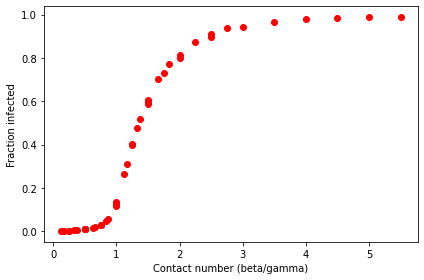

In [14]:
plot_sweep_frame(frame)

decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected')

#savefig('figs/chap14-fig01.pdf')

It turns out that the ratio `beta/gamma`, called the "contact number" is sufficient to predict the total number of infections; we don't have to know `beta` and `gamma` separately.

We can see that in the previous plot: when we plot the fraction infected versus the contact number, the results fall close to a curve.

### Analysis

In the book we figured out the relationship between $c$ and $s_{\infty}$ analytically.  Now we can compute it for a range of values:

In [19]:
import math

In [21]:
s_inf_array = linspace(0.0001, 0.9999, 101);

In [28]:
log_s_inf_array = np.array([math.log(x) for x in s_inf_array])

array([-9.21034037e+00, -4.59541789e+00, -3.90723449e+00, -3.50342946e+00,
       -3.21657847e+00, -2.99393389e+00, -2.81194512e+00, -2.65803222e+00,
       -2.52467920e+00, -2.40703491e+00, -2.30178541e+00, -2.20656607e+00,
       -2.11963040e+00, -2.03965176e+00, -1.96559870e+00, -1.89665343e+00,
       -1.83215655e+00, -1.77156868e+00, -1.71444294e+00, -1.66040494e+00,
       -1.60913796e+00, -1.56037160e+00, -1.51387322e+00, -1.46944122e+00,
       -1.42689971e+00, -1.38609438e+00, -1.34688905e+00, -1.30916296e+00,
       -1.27280855e+00, -1.23772954e+00, -1.20383948e+00, -1.17106041e+00,
       -1.13932179e+00, -1.10855960e+00, -1.07871555e+00, -1.04973641e+00,
       -1.02157347e+00, -9.94182006e-01, -9.67520870e-01, -9.41552131e-01,
       -9.16240733e-01, -8.91554218e-01, -8.67462473e-01, -8.43937513e-01,
       -8.20953280e-01, -7.98485474e-01, -7.76511398e-01, -7.55009818e-01,
       -7.33960842e-01, -7.13345806e-01, -6.93147181e-01, -6.73348475e-01,
       -6.53934160e-01, -

In [29]:
c_array = log_s_inf_array / (s_inf_array - 1);

`total_infected` is the change in $s$ from the beginning to the end.

In [32]:
frac_infected = 1 - s_inf_array
frac_infected_series = Series(frac_infected, index=c_array);

Now we can plot the analytic results and compare them to the simulations.

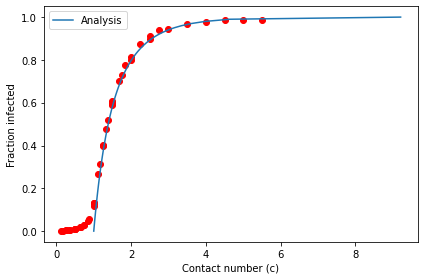

In [34]:
plot_sweep_frame(frame)
plt.plot(frac_infected_series, label='Analysis')

decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected')

#savefig('figs/chap14-fig02.pdf')

The agreement is generally good, except for values of `c` less than 1.

## Exercises

**Exercise:**  If we didn't know about contact numbers, we might have explored other possibilities, like the difference between `beta` and `gamma`, rather than their ratio.

Write a version of `plot_sweep_frame`, called `plot_sweep_frame_difference`, that plots the fraction infected versus the difference `beta-gamma`.

What do the results look like, and what does that imply? 

In [38]:
def plot_sweep_frame_difference(frame):
    """Plot the values from a SweepFrame.
    
    For each (beta, gamma), compute the contact number,
    beta/gamma
    
    frame: SweepFrame with one row per beta, one column per gamma
    """
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            frac_infected = column[beta]
            plt.plot(beta-gamma, frac_infected, 'ro')

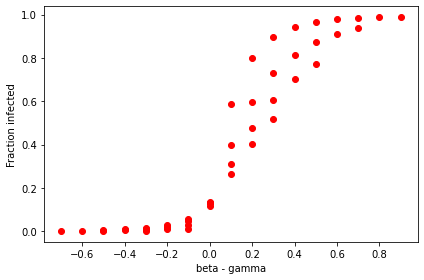

In [39]:
plot_sweep_frame_difference(frame)

decorate(xlabel='beta - gamma',
         ylabel='Fraction infected')

**Exercise:** Suppose you run a survey at the end of the semester and find that 26% of students had the Freshman Plague at some point.

What is your best estimate of `c`?

Hint: if you print `frac_infected_series`, you can read off the answer. 

In [44]:
# Solution goes here
frac_infected_df = pd.DataFrame(frac_infected_series)

frac_infected_df[(frac_infected_df[0] < 0.30) & (frac_infected_df[0] > 0.20)]

,0
1.181034,0.290042
1.173263,0.280044
1.165630,0.270046
1.158132,0.260048
1.150765,0.250050
1.143524,0.240052
1.136407,0.230054
1.129409,0.220056
1.122527,0.210058
1.115758,0.200060


The contact rate (c) would be 1.158132, based on the frac_infected_series values
